In [26]:
import pandas as pd
import locale
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

from pandas.tseries.offsets import MonthEnd

locale.setlocale(locale.LC_ALL, "sl_SI.utf8")

'sl_SI.utf8'

In [27]:
regije_filter = {
    "SO2": [
        "Koroška",
        "Osrednjeslovenska",
        "Posavska",
        "Savinjska",
        "Zasavska",
    ]
}


df = pd.read_csv("podatki/wide_df.csv").drop(columns="Postaja")
df.insert(
    loc=1,
    column="Datum",
    value=pd.to_datetime(
        df["Leto"].astype(str) + "-" + df["Mesec"].astype(str), format="%Y-%b"
    )
    + MonthEnd(0),
)
df = df.drop(columns=["Leto", "Mesec"])

In [28]:
so2_agg = df[df["Regija"].isin(regije_filter["SO2"])]
so2_agg = so2_agg.groupby(["Regija", "Datum"])["SO2"].mean().reset_index()
so2_agg.sort_values(by=["Datum", "Regija"], inplace=True)

so2_agg = so2_agg.pivot(index="Datum", columns="Regija", values="SO2")

region_names = so2_agg.columns.to_list()


In [29]:
descriptive_stats = so2_agg[region_names].describe()

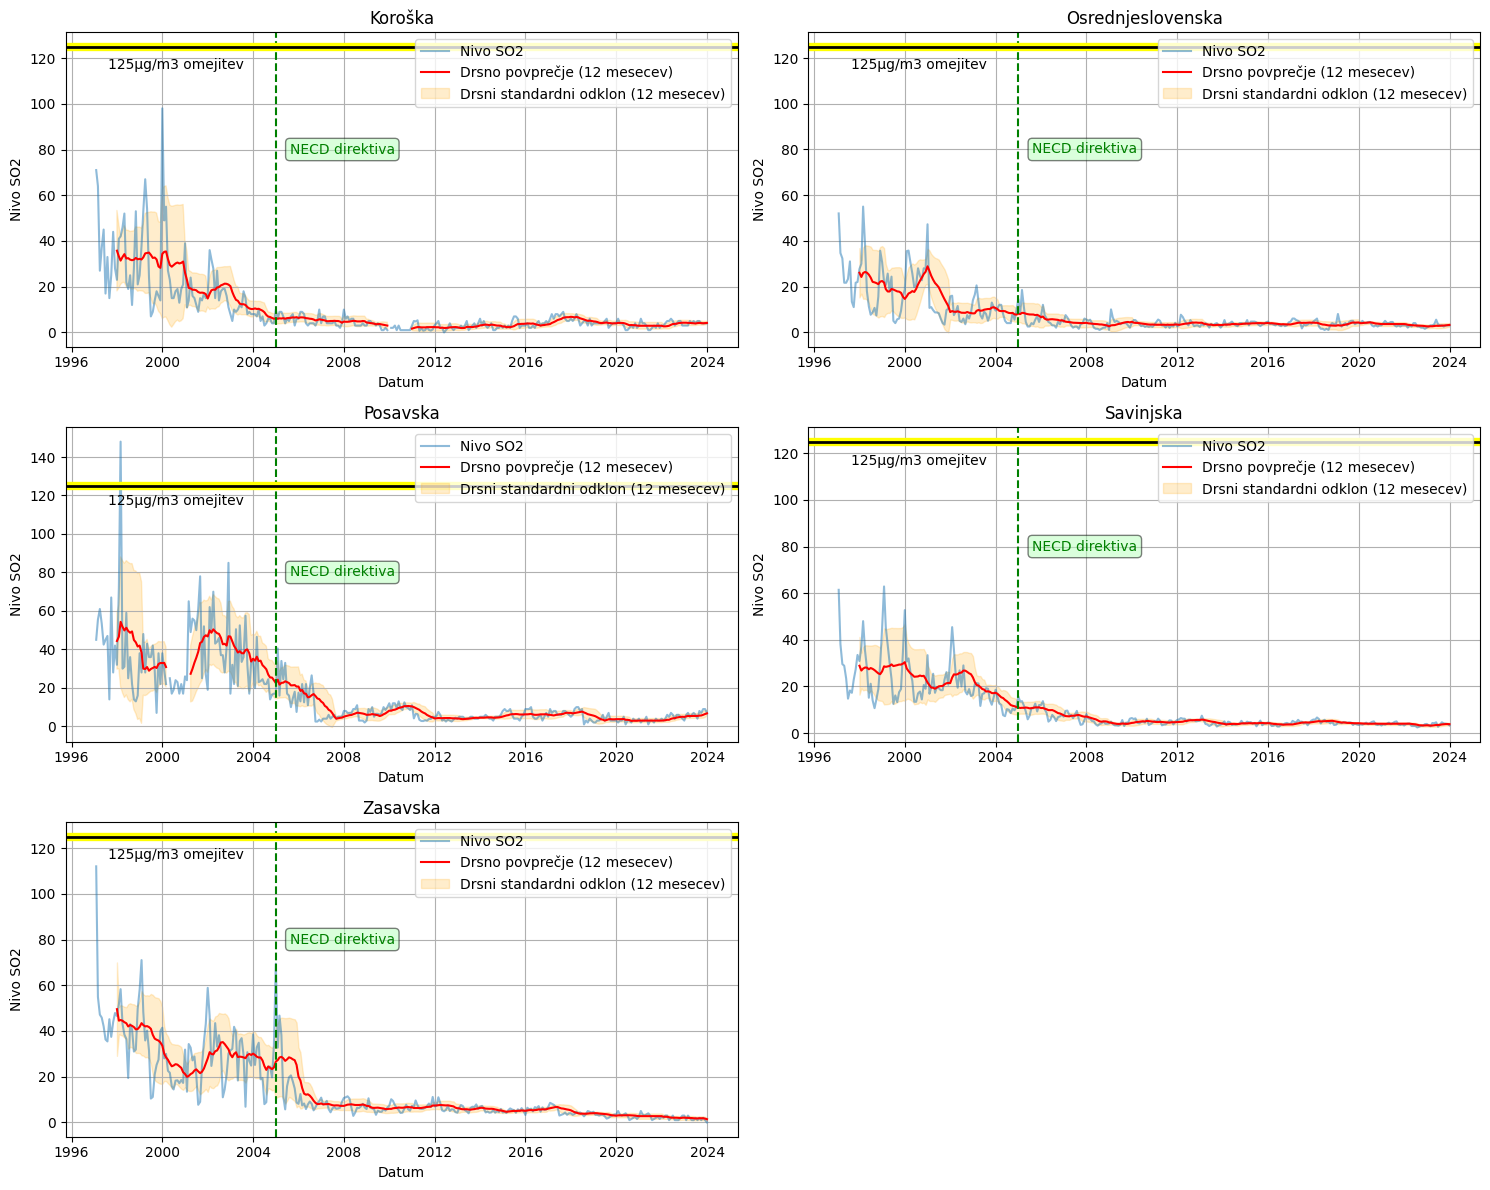

In [30]:
exclude = ['Time', 'Intervention', 'Time_Since_Intervention', 'Year', 'Month']
region_names = [item for item in region_names if item not in exclude]
# Calculate Rolling Mean and Rolling Standard Deviation (12-month window)
window_size = 12

rolling_mean = so2_agg[region_names].rolling(window=window_size).mean()
rolling_std = so2_agg[region_names].rolling(window=window_size).std()

# Plotting
num_regions = len(region_names)
num_cols = 2  # Adjust as needed for your screen/paper size
num_rows = (num_regions + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows)) # Adjusted subplot creation

# Flatten axes for easy indexing
axes = axes.flatten() # crucial if using subplots
for i, region in enumerate(region_names):
    ax = axes[i]  # Get the appropriate subplot axis

    ax.plot(so2_agg.index, so2_agg[region], label='Nivo SO2', alpha=0.5) # Added original level
    ax.plot(so2_agg.index, rolling_mean[region], label=f'Drsno povprečje ({window_size} mesecev)', color='red')

    ax.fill_between(so2_agg.index, rolling_mean[region] - rolling_std[region], rolling_mean[region] + rolling_std[region],
                    color='orange', alpha=0.2, label=f'Drsni standardni odklon ({window_size} mesecev)')

    ax.set_xlabel('Datum')
    ax.set_ylabel('Nivo SO2')
    ax.set_title(f'{region}')
    ax.legend(loc='upper right')
    ax.grid(True)

    # Add vertical line and annotation for NECD Directive
    necd_date = pd.to_datetime('2005-01-01')
    ax.axvline(necd_date, color='green', linestyle='--', label='NECD direktiva')
    ax.annotate("NECD direktiva", xy=(mdates.date2num(necd_date), 80), # Position annotation near the top
                xytext=(10, 0), textcoords='offset points', # Offset from the xy point
                bbox=dict(boxstyle='round,pad=0.3', fc='#B6FFBB', alpha=0.5), # Box properties
                ha='left', va='center', color='green')
    
    ax.axhline(125, color='yellow',linewidth=6)
    ax.axhline(125, color='black',linewidth=2)
    ax.annotate("125µg/m3 omejitev", xy=(pd.to_datetime('1997-01-01'),115),xytext=(10,3),textcoords='offset points',ha='left',va='center',color='black')

    
if num_regions < len(axes):
    for i in range(num_regions, len(axes)):
        fig.delaxes(axes[i])


plt.tight_layout() 
plt.savefig("grafi/trend_gibanja_SO2_regije.png")
plt.show()


In [31]:
so2_presezki = pd.read_csv("podatki/df_regije/presezki/SO2.csv")

so2_presezki = so2_presezki.groupby(["Regija"])[
    ["SO2 - Urnih presežkov", "SO2 - Dnevnih presežkov"]
].sum().reset_index()

so2_presezki.sort_values(by=so2_presezki.columns[1:].to_list(),ascending=False,inplace=True,ignore_index=True)
so2_presezki.loc[4] = ["Osrednjeslovenska", 0,0]

so2_presezki.set_index('Regija',inplace=True)

so2_presezki


,SO2 - Urnih presežkov,SO2 - Dnevnih presežkov
Regija,,
Zasavska,521,73
Savinjska,175,6
Posavska,116,21
Koroška,4,0
Osrednjeslovenska,0,0
